<a href="https://colab.research.google.com/github/dokin0802/SinGAN/blob/master/category_sin3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import os
import glob
path = '/content/drive/MyDrive/architecture_aug/ex2/augf2/g'
g = glob.glob(path+'/*')

def rename(files):
  for i,f in enumerate(files):
      os.rename(f, os.path.join(path, 'g_' + '{0:03d}.jpg'.format(i)))

In [7]:
rename(g)


In [1]:
import os.path
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from pathlib import Path
from tqdm import tqdm
from time import perf_counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score
from IPython.display import Markdown, display

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [8]:
dir_ = Path('/content/drive/MyDrive/architecture_aug/ex2/augf2')
filepaths = list(dir_.glob(r'**/*.jpg'))
def proc_img(filepath):
    """
   		이미지데이터의 경로와 label데이터로 데이터프레임 만들기 
    """

    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # 경로와 라벨 concatenate
    df = pd.concat([filepath, labels], axis=1)

    # index 재설정
    df = df.sample(frac=1,random_state=0).reset_index(drop = True)
    
    return df

df = proc_img(filepaths)
df.head(5)

,Filepath,Label
0,/content/drive/MyDrive/architecture_aug/ex2/au...,i
1,/content/drive/MyDrive/architecture_aug/ex2/au...,b
2,/content/drive/MyDrive/architecture_aug/ex2/au...,g
3,/content/drive/MyDrive/architecture_aug/ex2/au...,b
4,/content/drive/MyDrive/architecture_aug/ex2/au...,b


In [9]:
print(f'Number of pictures: {df.shape[0]}\n')
print(f'Number of different labels: {len(df.Label.unique())}\n')
print(f'Labels: {df.Label.unique()}')

Number of pictures: 1450

Number of different labels: 6

Labels: ['i' 'b' 'g' 'p' 'r' 'd']


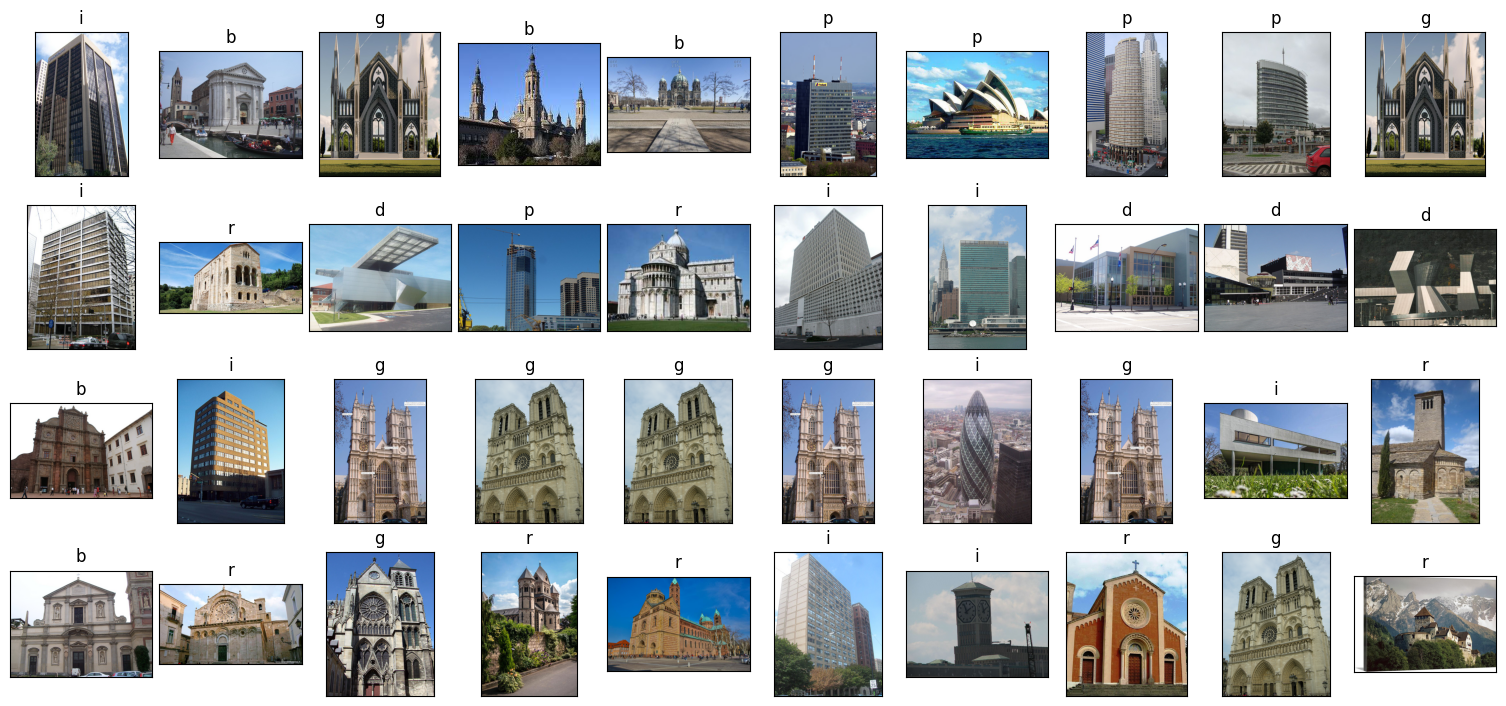

In [10]:
# 데이터 확인
fig, axes = plt.subplots(nrows=4, ncols=10, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.Filepath[i]))
    ax.set_title(df.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

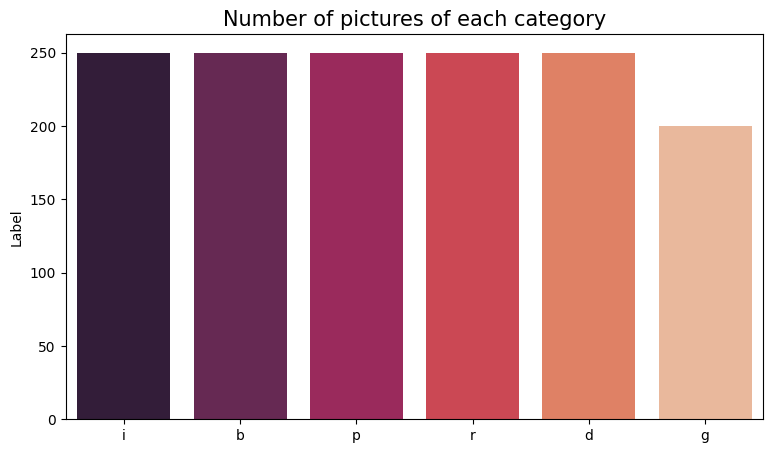

In [11]:
vc = df['Label'].value_counts()
plt.figure(figsize=(9,5))
sns.barplot(x = vc.index, y = vc, palette = "rocket")
plt.title("Number of pictures of each category", fontsize = 15)
plt.show()

In [12]:
train_df =df

dir_ = Path('/content/drive/MyDrive/architecture_small/test')
filepaths = list(dir_.glob(r'**/*.jpg'))
test_df = proc_img(filepaths)

In [13]:
import numpy as np
import tensorflow as tf


from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split=0.20)

train_gen = train_datagen.flow_from_directory('/content/drive/MyDrive/architecture_aug/ex2/augf2',
                                                 target_size = (150, 150),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',subset='training')
val_gen  = train_datagen.flow_from_directory('/content/drive/MyDrive/architecture_aug/ex2/augf2',
                                                 target_size = (150, 150),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',subset='validation')

Found 1160 images belonging to 6 classes.
Found 290 images belonging to 6 classes.


In [14]:
# Initialising the CNN
cnn = tf.keras.models.Sequential()

# Step 1 - Convolution
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[150, 150, 3]))

# Step 2 - Pooling
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Adding convolutional layer
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Step 3 - Flattening
cnn.add(tf.keras.layers.Flatten())

# Step 4 - Full Connection
cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))

# Step 5 - Output Layer
cnn.add(tf.keras.layers.Dense(units=6, activation='softmax'))

# Compiling the CNN
cnn.compile(optimizer = 'adam', 
            loss = 'categorical_crossentropy', 
            metrics = ['accuracy'])
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 41472)             0         
                                                                 
 dense (Dense)               (None, 128)               5

In [15]:
cnn.fit(x = train_gen, validation_data = val_gen, epochs = 10)

Epoch 1/10
37/37 [==============================] - 512s 14s/step - loss: 1.7319 - accuracy: 0.2991 - val_loss: 1.4127 - val_accuracy: 0.3897
Epoch 2/10
37/37 [==============================] - 12s 319ms/step - loss: 1.0664 - accuracy: 0.5940 - val_loss: 1.4516 - val_accuracy: 0.4345
Epoch 3/10
37/37 [==============================] - 12s 316ms/step - loss: 0.7448 - accuracy: 0.7233 - val_loss: 1.5255 - val_accuracy: 0.4552
Epoch 4/10
37/37 [==============================] - 12s 319ms/step - loss: 0.3738 - accuracy: 0.8836 - val_loss: 1.7395 - val_accuracy: 0.4138
Epoch 5/10
37/37 [==============================] - 12s 319ms/step - loss: 0.1666 - accuracy: 0.9647 - val_loss: 1.8535 - val_accuracy: 0.4586
Epoch 6/10
37/37 [==============================] - 12s 318ms/step - loss: 0.0985 - accuracy: 0.9871 - val_loss: 2.0172 - val_accuracy: 0.4586
Epoch 7/10
37/37 [==============================] - 12s 319ms/step - loss: 0.0766 - accuracy: 0.9931 - val_loss: 2.1985 - val_accuracy: 0.4448


In [16]:
def create_gen():
    # 생성기 및 데이터 증강으로 이미지 로드
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.1
    )

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath', # 파일위치 열이름
        y_col='Label', # 클래스 열이름
        target_size=(224, 224), # 이미지 사이즈
        color_mode='rgb', # 이미지 채널수
        class_mode='categorical', # Y값(Label값)
        batch_size=32,
        shuffle=True, # 데이터를 섞을지 여부
        seed=0,
        subset='training', # train 인지 val인지 설정
        rotation_range=30, # 회전제한 각도 30도
        zoom_range=0.15, # 확대 축소 15%
        width_shift_range=0.2, # 좌우이동 20%
        height_shift_range=0.2, # 상하이동 20%
        shear_range=0.15, # 반시계방햐의 각도
        horizontal_flip=True, # 좌우 반전 True
        fill_mode="nearest"
        # 이미지 변경시 보완 방법 (constant, nearest, reflect, wrap) 4개 존재
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='validation',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )
    
    return train_generator,test_generator,train_images,val_images,test_images

In [17]:
models = {
    "DenseNet121": {"model":tf.keras.applications.DenseNet121, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "DenseNet201": {"model":tf.keras.applications.DenseNet201, "perf":0},
    "EfficientNetB0": {"model":tf.keras.applications.EfficientNetB0, "perf":0},
    "EfficientNetB1": {"model":tf.keras.applications.EfficientNetB1, "perf":0},
    "InceptionV3": {"model":tf.keras.applications.InceptionV3, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "MobileNetV3Large": {"model":tf.keras.applications.MobileNetV3Large, "perf":0},
    "ResNet152V2": {"model":tf.keras.applications.ResNet152V2, "perf":0},
    "ResNet50": {"model":tf.keras.applications.ResNet50, "perf":0},
    "ResNet50V2": {"model":tf.keras.applications.ResNet50V2, "perf":0},
    "VGG19": {"model":tf.keras.applications.VGG19, "perf":0},
    "VGG16": {"model":tf.keras.applications.VGG16, "perf":0},
    "Xception": {"model":tf.keras.applications.Xception, "perf":0}
}
# Create the generators
train_generator,test_generator,train_images,val_images,test_images=create_gen()
print('\n')

def get_model(model):
# Load the pretained model
    kwargs =    {'input_shape':(224, 224, 3),
                'include_top':False,
                'weights':'imagenet',
                'pooling':'avg'}
    
    pretrained_model = model(**kwargs)
    pretrained_model.trainable = False # 레이어를 동결 시켜서 훈련중 손실을 최소화 한다.
    
    inputs = pretrained_model.input

    x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    outputs = tf.keras.layers.Dense(6, activation='softmax')(x)
    # 라벨 개수가 8개이기 때문에 Dencs도 8로 설정
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Train모델 학습
for name, model in models.items():
    
    # 전이 학습 모델 가져오기
    m = get_model(model['model'])
    models[name]['model'] = m
    
    start = perf_counter()
    
    # 모델 학습
    history = m.fit(train_images,validation_data=val_images,epochs=1,verbose=0)
    
    # 학습시간과 val_accuracy 저장
    duration = perf_counter() - start
    duration = round(duration,2)
    models[name]['perf'] = duration
    print(f"{name:20} trained in {duration} sec")
    
    val_acc = history.history['val_accuracy']
    models[name]['val_acc'] = [round(v,4) for v in val_acc]

Found 1305 validated image filenames belonging to 6 classes.
Found 145 validated image filenames belonging to 6 classes.
Found 300 validated image filenames belonging to 6 classes.


29084464/29084464 [==============================] - 2s 0us/step
DenseNet121          trained in 22.14 sec
9406464/9406464 [==============================] - 1s 0us/step
MobileNetV2          trained in 17.02 sec
74836368/74836368 [==============================] - 4s 0us/step
DenseNet201          trained in 26.68 sec
16705208/16705208 [==============================] - 2s 0us/step
EfficientNetB0       trained in 21.67 sec
27018416/27018416 [==============================] - 2s 0us/step
EfficientNetB1       trained in 24.99 sec
87910968/87910968 [==============================] - 5s 0us/step
InceptionV3          trained in 20.37 sec
12683000/12683000 [==============================] - 2s 0us/step
MobileNetV3Large     trained in 18.13 sec
234545216/234545216 [==============================] - 12s 0us/step
Re

In [18]:
# test데이터로 모델 성능 예측
for name, model in models.items():
    
    # Predict the label of the test_images
    pred = models[name]['model'].predict(test_images)
    pred = np.argmax(pred,axis=1)

    # Map the label
    labels = (train_images.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]

    y_test = list(test_df.Label)
    acc = accuracy_score(y_test,pred)
    models[name]['acc'] = round(acc,4)
    print(f'**{name} has a {acc * 100:.2f}% accuracy on the test set**')
   
# Create a DataFrame with the results
models_result = []

for name, v in models.items():
    models_result.append([ name, models[name]['val_acc'][-1], 
                          models[name]['acc'],
                          models[name]['perf']])
    
df_results = pd.DataFrame(models_result, 
                          columns = ['model','val_accuracy','accuracy','Training time (sec)'])
df_results.sort_values(by='accuracy', ascending=False, inplace=True)
df_results.reset_index(inplace=True,drop=True)
df_results

10/10 [==============================] - 154s 17s/step
**DenseNet121 has a 57.67% accuracy on the test set**
10/10 [==============================] - 4s 336ms/step
**MobileNetV2 has a 58.00% accuracy on the test set**
10/10 [==============================] - 7s 335ms/step
**DenseNet201 has a 63.00% accuracy on the test set**
10/10 [==============================] - 5s 327ms/step
**EfficientNetB0 has a 16.67% accuracy on the test set**
10/10 [==============================] - 5s 330ms/step
**EfficientNetB1 has a 16.67% accuracy on the test set**
10/10 [==============================] - 5s 383ms/step
**InceptionV3 has a 56.33% accuracy on the test set**
10/10 [==============================] - 4s 334ms/step
**MobileNetV3Large has a 23.67% accuracy on the test set**
10/10 [==============================] - 6s 349ms/step
**ResNet152V2 has a 62.00% accuracy on the test set**
10/10 [==============================] - 5s 357ms/step
**ResNet50 has a 31.33% accuracy on the test set**
10/10 [====

,model,val_accuracy,accuracy,Training time (sec)
0,DenseNet201,0.7517,0.6300,26.68
1,ResNet152V2,0.7793,0.6200,25.40
2,Xception,0.7448,0.6100,17.26
3,MobileNetV2,0.7241,0.5800,17.02
4,DenseNet121,0.8138,0.5767,22.14
5,ResNet50V2,0.7655,0.5767,17.37
6,InceptionV3,0.7379,0.5633,20.37
7,VGG16,0.5655,0.4600,14.61
8,VGG19,0.4069,0.3367,16.57
9,ResNet50,0.3448,0.3133,18.13


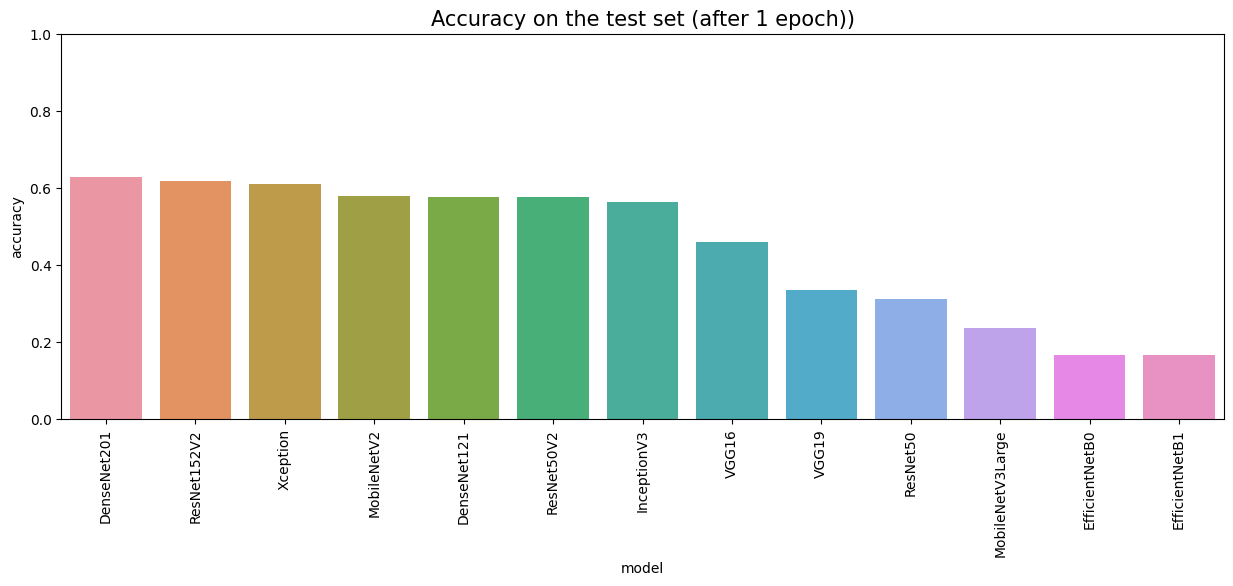

In [19]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'accuracy', data = df_results)
plt.title('Accuracy on the test set (after 1 epoch))', fontsize = 15)
plt.ylim(0,1)
plt.xticks(rotation=90)
plt.show()

In [20]:
train_generator,test_generator,train_images,val_images,test_images=create_gen()

model = get_model(tf.keras.applications.ResNet50V2)
history = model.fit(train_images,validation_data=val_images,epochs=7)

Found 1305 validated image filenames belonging to 6 classes.
Found 145 validated image filenames belonging to 6 classes.
Found 300 validated image filenames belonging to 6 classes.
Epoch 1/7
41/41 [==============================] - 17s 325ms/step - loss: 0.2942 - accuracy: 0.6038 - val_loss: 0.1731 - val_accuracy: 0.8069
Epoch 2/7
41/41 [==============================] - 12s 301ms/step - loss: 0.1489 - accuracy: 0.8207 - val_loss: 0.1496 - val_accuracy: 0.8345
Epoch 3/7
41/41 [==============================] - 13s 304ms/step - loss: 0.1042 - accuracy: 0.8835 - val_loss: 0.1387 - val_accuracy: 0.8483
Epoch 4/7
41/41 [==============================] - 12s 303ms/step - loss: 0.0773 - accuracy: 0.9234 - val_loss: 0.1405 - val_accuracy: 0.8552
Epoch 5/7
41/41 [==============================] - 13s 307ms/step - loss: 0.0556 - accuracy: 0.9479 - val_loss: 0.1224 - val_accuracy: 0.8690
Epoch 6/7
41/41 [==============================] - 12s 304ms/step - loss: 0.0367 - accuracy: 0.9747 - val_los

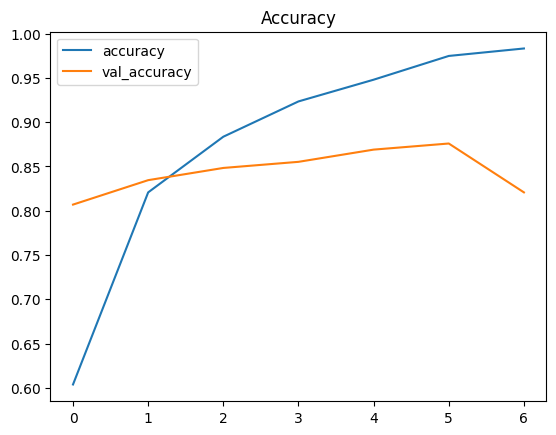

In [21]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

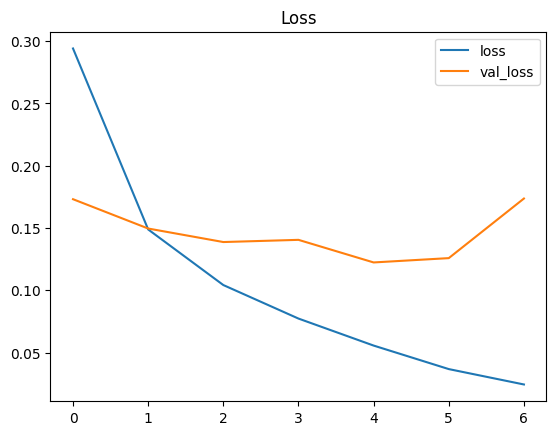

In [22]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [23]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]
    
y_test = list(test_df.Label)
acc = accuracy_score(y_test,pred)
print(f'Accuracy on the test set: {acc * 100:.2f}%')

10/10 [==============================] - 4s 332ms/step
Accuracy on the test set: 64.00%


In [24]:
class_report = classification_report(y_test, pred, zero_division=1)
print(class_report)

              precision    recall  f1-score   support

           b       0.80      0.90      0.85        50
           d       0.70      0.76      0.73        50
           g       0.62      0.10      0.17        50
           i       0.74      0.68      0.71        50
           p       0.54      0.52      0.53        50
           r       0.50      0.88      0.64        50

    accuracy                           0.64       300
   macro avg       0.65      0.64      0.60       300
weighted avg       0.65      0.64      0.60       300



In [25]:
train_generator,test_generator,train_images,val_images,test_images=create_gen()

model = get_model(tf.keras.applications.Xception)
history = model.fit(train_images,validation_data=val_images,epochs=7)

Found 1305 validated image filenames belonging to 6 classes.
Found 145 validated image filenames belonging to 6 classes.
Found 300 validated image filenames belonging to 6 classes.
Epoch 1/7
41/41 [==============================] - 17s 335ms/step - loss: 0.3044 - accuracy: 0.5939 - val_loss: 0.1947 - val_accuracy: 0.8207
Epoch 2/7
41/41 [==============================] - 13s 312ms/step - loss: 0.1818 - accuracy: 0.7732 - val_loss: 0.1666 - val_accuracy: 0.8069
Epoch 3/7
41/41 [==============================] - 13s 311ms/step - loss: 0.1446 - accuracy: 0.8169 - val_loss: 0.1420 - val_accuracy: 0.8414
Epoch 4/7
41/41 [==============================] - 13s 312ms/step - loss: 0.1260 - accuracy: 0.8452 - val_loss: 0.1384 - val_accuracy: 0.8414
Epoch 5/7
41/41 [==============================] - 13s 312ms/step - loss: 0.1046 - accuracy: 0.8797 - val_loss: 0.1311 - val_accuracy: 0.8483
Epoch 6/7
41/41 [==============================] - 13s 308ms/step - loss: 0.0887 - accuracy: 0.9004 - val_los

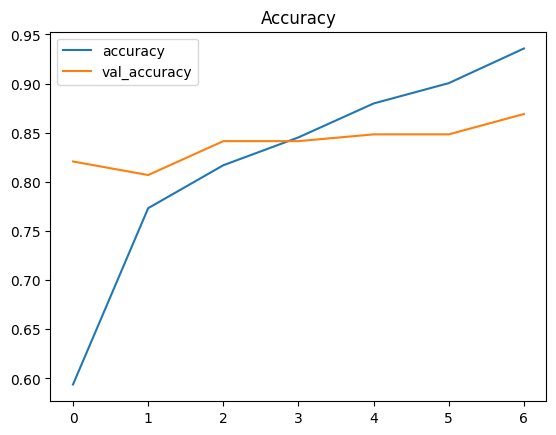

In [26]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

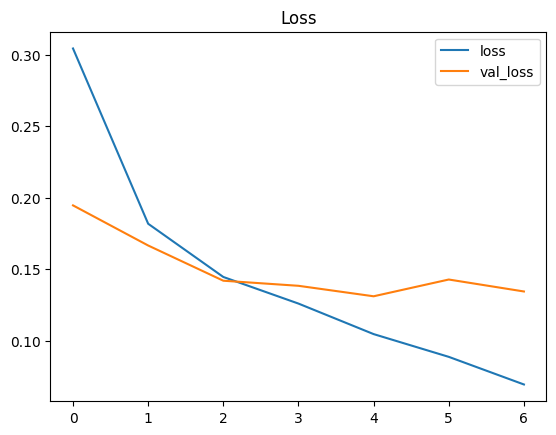

In [27]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [28]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]
    
y_test = list(test_df.Label)
acc = accuracy_score(y_test,pred)
print(f'Accuracy on the test set: {acc * 100:.2f}%')

10/10 [==============================] - 4s 330ms/step
Accuracy on the test set: 65.00%


In [29]:
class_report = classification_report(y_test, pred, zero_division=1)
print(class_report)

              precision    recall  f1-score   support

           b       0.88      0.86      0.87        50
           d       0.73      0.80      0.76        50
           g       0.33      0.02      0.04        50
           i       0.88      0.58      0.70        50
           p       0.57      0.68      0.62        50
           r       0.48      0.96      0.64        50

    accuracy                           0.65       300
   macro avg       0.64      0.65      0.60       300
weighted avg       0.64      0.65      0.60       300



In [30]:
train_generator,test_generator,train_images,val_images,test_images=create_gen()

model = get_model(tf.keras.applications.DenseNet201)
history = model.fit(train_images,validation_data=val_images,epochs=7)


Found 1305 validated image filenames belonging to 6 classes.
Found 145 validated image filenames belonging to 6 classes.
Found 300 validated image filenames belonging to 6 classes.
Epoch 1/7
41/41 [==============================] - 27s 383ms/step - loss: 0.2907 - accuracy: 0.6230 - val_loss: 0.1798 - val_accuracy: 0.8000
Epoch 2/7
41/41 [==============================] - 13s 307ms/step - loss: 0.1607 - accuracy: 0.8192 - val_loss: 0.1354 - val_accuracy: 0.8690
Epoch 3/7
41/41 [==============================] - 13s 306ms/step - loss: 0.1211 - accuracy: 0.8705 - val_loss: 0.1191 - val_accuracy: 0.8828
Epoch 4/7
41/41 [==============================] - 13s 306ms/step - loss: 0.0970 - accuracy: 0.9027 - val_loss: 0.1053 - val_accuracy: 0.8759
Epoch 5/7
41/41 [==============================] - 13s 306ms/step - loss: 0.0808 - accuracy: 0.9111 - val_loss: 0.1165 - val_accuracy: 0.8690
Epoch 6/7
41/41 [==============================] - 12s 306ms/step - loss: 0.0619 - accuracy: 0.9479 - val_los

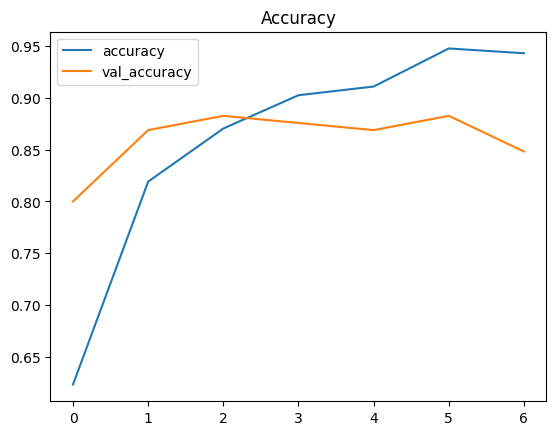

In [31]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

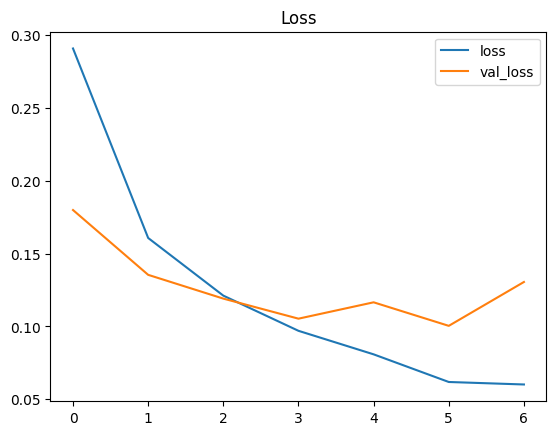

In [32]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [33]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]
    
y_test = list(test_df.Label)
acc = accuracy_score(y_test,pred)
print(f'Accuracy on the test set: {acc * 100:.2f}%')

10/10 [==============================] - 6s 333ms/step
Accuracy on the test set: 63.33%


In [34]:
class_report = classification_report(y_test, pred, zero_division=1)
print(class_report)

              precision    recall  f1-score   support

           b       0.91      0.78      0.84        50
           d       0.79      0.76      0.78        50
           g       0.17      0.02      0.04        50
           i       0.77      0.72      0.74        50
           p       0.70      0.62      0.66        50
           r       0.40      0.90      0.56        50

    accuracy                           0.63       300
   macro avg       0.62      0.63      0.60       300
weighted avg       0.62      0.63      0.60       300



In [ ]:
VGG16

In [35]:
train_generator,test_generator,train_images,val_images,test_images=create_gen()

model = get_model(tf.keras.applications.VGG16)
history = model.fit(train_images,validation_data=val_images,epochs=7)

Found 1305 validated image filenames belonging to 6 classes.
Found 145 validated image filenames belonging to 6 classes.
Found 300 validated image filenames belonging to 6 classes.
Epoch 1/7
41/41 [==============================] - 14s 311ms/step - loss: 0.4442 - accuracy: 0.3425 - val_loss: 0.3774 - val_accuracy: 0.5517
Epoch 2/7
41/41 [==============================] - 13s 307ms/step - loss: 0.3185 - accuracy: 0.6360 - val_loss: 0.2791 - val_accuracy: 0.6483
Epoch 3/7
41/41 [==============================] - 13s 306ms/step - loss: 0.2449 - accuracy: 0.7027 - val_loss: 0.2270 - val_accuracy: 0.7241
Epoch 4/7
41/41 [==============================] - 12s 303ms/step - loss: 0.2061 - accuracy: 0.7632 - val_loss: 0.2035 - val_accuracy: 0.7931
Epoch 5/7
41/41 [==============================] - 12s 302ms/step - loss: 0.1839 - accuracy: 0.7762 - val_loss: 0.1832 - val_accuracy: 0.8000
Epoch 6/7
41/41 [==============================] - 12s 304ms/step - loss: 0.1733 - accuracy: 0.7885 - val_los

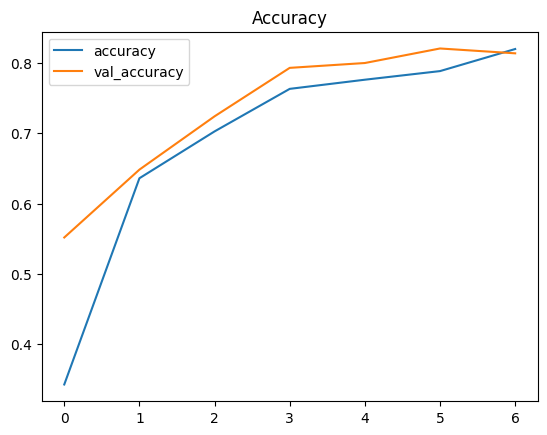

In [36]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

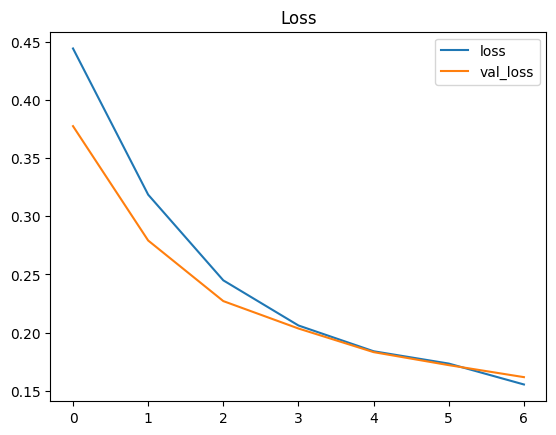

In [37]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [38]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]
    
y_test = list(test_df.Label)
acc = accuracy_score(y_test,pred)
print(f'Accuracy on the test set: {acc * 100:.2f}%')

10/10 [==============================] - 3s 327ms/step
Accuracy on the test set: 63.33%


In [39]:
class_report = classification_report(y_test, pred, zero_division=1)
print(class_report)

              precision    recall  f1-score   support

           b       0.71      0.98      0.82        50
           d       0.66      0.76      0.70        50
           g       0.68      0.26      0.38        50
           i       0.70      0.62      0.66        50
           p       0.53      0.48      0.51        50
           r       0.54      0.70      0.61        50

    accuracy                           0.63       300
   macro avg       0.64      0.63      0.61       300
weighted avg       0.64      0.63      0.61       300

